In [ ]:
!nvidia-smi

Thu Nov  9 19:58:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


In [ ]:
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
#is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
print(is_cuda_gpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True


# LIBRARIES and Bibliotheques

In [ ]:
# Generate packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pathlib
import time
import os
import shutil
import psutil
import random
import zipfile
from google.colab import drive
import sys
from sklearn.metrics import f1_score, recall_score, accuracy_score

# TensorFlow and Keras Packages

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model

# Configuration for Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ajoutez le chemin de votre Google Drive au module sys.path
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ML/Model/')

## Fonction

In [ ]:

def unzip_zipfile(zipfile_path, drive_path = "/content/drive/MyDrive/Colab Notebooks/ML/Model/RecyclableObjectDetected/", target_dir = '/content'):

    # drive.mount('/gdrive')
    # %cd /gdriv
    # drive.mount('/content/drive')  # Montez Google Drive pour accéder au fichier ZIP

    # Spécifiez le chemin complet du fichier ZIP dans Google Drive
    zip_path = drive_path + zipfile_path

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)

In [ ]:
zipfile_path = 'dataset.zip'
unzip_zipfile(zipfile_path)

In [ ]:
def is_running_on_colab():
    # Vérifie si le processus Python s'exécute sous Google Colab
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [ ]:
if is_running_on_colab():
    print("Le code s'exécute sur Google Colab.")
    dir_original = "/content/dataset"
else:
    print("Le code s'exécute en dehors de Google Colab.")
    dir_original = "/Users/jeanmermozeffi/Documents/CYCLE INGENIEUR TEK/CYCLE INGENIEUR 3/Stage Ete/Waste Classification Dataset/dataset"

Le code s'exécute sur Google Colab.


# DIRECTORIES

In [ ]:
data_dir = pathlib.Path(dir_original)

if data_dir.exists():
    print("Le chemin existe.")

organic_dir = os.path.join(dir_original, "organic")
recyclable_dir = os.path.join(dir_original, "recyclable")

len(os.listdir(organic_dir)), len(os.listdir(recyclable_dir))

Le chemin existe.


(13880, 10825)

In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ML/Model/RecyclableObjectDetected/CodeSource')

In [ ]:
MODEL_DIR = '/content/drive/MyDrive/Colab Notebooks/ML/Model/RecyclableObjectDetected/ModelAPI'

In [ ]:
# from image_dataset_analyzer_module import ImageDatasetAnalyzer

In [ ]:
# analyzer = ImageDatasetAnalyzer(dir_original)

In [ ]:
# analyzer.build_data_frame()

In [ ]:
set_samples = ['train', 'validation', 'test']
print("set_samples: ", set_samples, "\n")

set_samples:  ['train', 'validation', 'test'] 


# PARAMETERS

In [ ]:
batch_size = 32

nb_train_samples = 207522           # no of training samples
nb_validation_samples = 51880       # no of validation samples
nb_test_samples = 86468             # no of testing samples
# image size (Model Medium)
img_width, img_height = 224, 224

n_class = 2

epochs = 20

# Fonctions definitions

In [ ]:
def process_image(image):
    image = cv2.imread(image)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
    cv2.imshow(image)

In [ ]:
def custom_data_split(data_directory, train_ratio=0.7, val_ratio=0.10, test_ratio=0.20):
    remove_ds_store_files(data_directory)
    # Assurez-vous que les proportions sont valides
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("Les proportions doivent totaliser 1.0.")

    # Créez les répertoires de destination pour l'entraînement, la validation et le test
    train_dir = "train"
    val_dir = "validation"
    test_dir = "test"

    # Supprimez les répertoires s'ils existent déjà
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)

    os.makedirs(train_dir)
    os.makedirs(val_dir)
    os.makedirs(test_dir)

    # Parcourez le répertoire source et copiez les images dans les répertoires de destination
    for class_folder in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_folder)
        if not os.path.isdir(class_path):
            continue  # Ignorer les fichiers qui ne sont pas des répertoires

        train_size = int(len(os.listdir(class_path)) * train_ratio)
        val_size = int(len(os.listdir(class_path)) * val_ratio)

        file_list = os.listdir(class_path)
        random.shuffle(file_list)

        for i, filename in enumerate(file_list):
            source_path = os.path.join(class_path, filename)
            if i < train_size:
                destination_path = os.path.join(train_dir, class_folder, filename)
            elif i < train_size + val_size:
                destination_path = os.path.join(val_dir, class_folder, filename)
            else:
                destination_path = os.path.join(test_dir, class_folder, filename)

            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            shutil.copy(source_path, destination_path)

    return train_dir, val_dir, test_dir

In [ ]:
def remove_ds_store_files(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename == ".DS_Store":
                file_path = os.path.join(root, filename)
                os.remove(file_path)

In [ ]:
def display_time_in_minutes(start_time):
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60  # Convertir de secondes à minutes
    return elapsed_time_minutes

# Saving

In [ ]:
def saving_model(model, model_name="model.h5", path_model=''):
  path_model = '/content/drive/MyDrive/Colab Notebooks/ML/Model/RecyclableObjectDetected/ModelAPI'
  path_model = os.path.join(path_model, model_name)

  model.save(path_model)

## Plot Fonction

In [ ]:
def plot_learning_curve(history_train, plot_name, figsize=(10, 5)):
    plt.figure(figsize=(10, 5))
    history_data = history_train.history

    if plot_name:
        plt.plot(list(range(len(history_data[plot_name]))), history_data[plot_name], label=f"{plot_name.capitalize()} d'apprentissage")
        plt.plot(list(range(len(history_data[f"val_{plot_name}"]))), history_data[f"val_{plot_name}"], label=f"{plot_name.capitalize()} de test")
        plt.xlabel('Epochs')
        plt.ylabel(plot_name.capitalize())
        plt.title(f"Courbes Learning Curve {plot_name.capitalize()} en fonction du nombre d'epochs")
        plt.legend()
        plt.grid(True)
        plt.show()

## Load model

In [ ]:
# @st.cache_data()
def load(load_name=''):
    model_path = os.path.join(MODEL_DIR, load_name)
    model = load_model(model_path, compile=True)
    return model

# Avaluation Model

In [ ]:
def model_evaluate(model, test_dataset):
  loss, accuracy = model.evaluate(test_dataset)
  # Faites des prédictions sur les données de test
  predictions = model.predict(test_dataset)

  # Convertissez les prédictions en classes
  # y_pred_classes = y_pred.argmax(axis=-1)
  predicted_classes = tf.argmax(predictions, axis=1).numpy()

  # Obtenez les vraies étiquettes à partir de test_dataset
  true_classes = []
  for images, labels in test_dataset:
      true_classes.extend(tf.argmax(labels, axis=1).numpy())

  # y_true = []
  # for images, labels in test_dataset:
  #     y_true.extend(tf.argmax(labels, axis=1))

  # Calculez le F-score et le rappel
  f1 = f1_score(true_classes, predicted_classes, average='weighted')  # Vous pouvez choisir "micro", "macro", "weighted", etc., comme méthode de calcul
  recall = recall_score(true_classes, predicted_classes, average='weighted')  # Vous pouvez également spécifier l'argument "average" en fonction de vos besoins
  # Calculez la précision
  precission = accuracy_score(true_classes, predicted_classes)

  print(f'Précision (Accuracy) : {round(accuracy*100, 2)} %')
  print(f'Perte (Loss): {round(loss, 2)} => {round(loss*100, 2)} %')
  print(f'F1-score : {round(f1*100, 2)} %')
  print(f'Rappel (Recall) : {round(recall*100, 2)} %')
  print(f'Précision : {round(precission*100, 2)} %')

  return loss, accuracy, f1, recall, precission

In [ ]:
train_data_dir, validation_data_dir, test_data_dir = custom_data_split(dir_original)

In [ ]:
os.listdir(train_data_dir)

['recyclable', 'organic']

In [ ]:
remove_ds_store_files(train_data_dir)

In [ ]:
train_r_dir = os.path.join(train_data_dir, "recyclable")
train_o_dir = os.path.join(train_data_dir, "organic")

In [ ]:
len(os.listdir(train_r_dir)), len(os.listdir(train_o_dir))

(7577, 9716)

In [ ]:
recyclable_images = [os.path.join(train_r_dir, filename) for filename in os.listdir(train_r_dir)]
organic_images = [os.path.join(train_o_dir, filename) for filename in os.listdir(train_o_dir)]

In [ ]:
import matplotlib.image as mpimg

In [ ]:
r_index = 5680
o_index = 1496
img_r = mpimg.imread(recyclable_images[r_index])
img_o = mpimg.imread(organic_images[o_index])

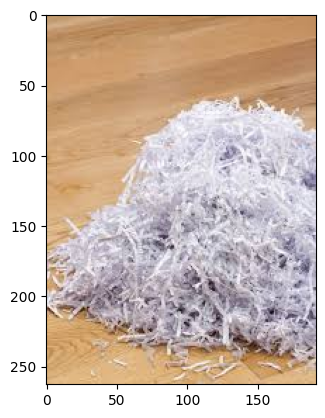

In [ ]:
plt.imshow(img_r)

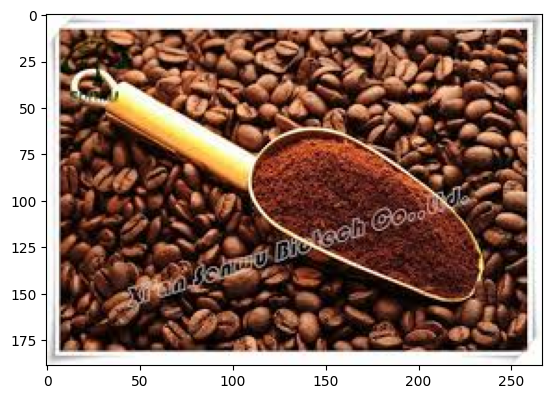

In [ ]:
plt.imshow(img_o)

# Data formation

In [ ]:
# input shape
if keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [ ]:
train_dataset = image_dataset_from_directory(train_data_dir,
                                             shuffle=True,
                                             color_mode= "rgb",
                                             batch_size=batch_size,
                                             image_size=(img_width, img_height),
                                             label_mode='categorical')


validation_dataset = image_dataset_from_directory(validation_data_dir,
                                                  shuffle=True,
                                                  color_mode= "rgb",
                                                  batch_size=batch_size,
                                                  image_size=(img_width, img_height),
                                                  label_mode='categorical')


test_dataset = image_dataset_from_directory(test_data_dir,
                                            shuffle=True,
                                            color_mode= "rgb",
                                            batch_size=batch_size,
                                            image_size=(img_width, img_height),
                                            label_mode='categorical')

Found 17293 files belonging to 2 classes.
Found 2470 files belonging to 2 classes.
Found 4942 files belonging to 2 classes.


# L'utilisation de la méthode prefetch(buffer_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Chargez vos ensembles de données et appliquez prefetch
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Normalizer

In [ ]:
train_dataset = train_dataset.map(lambda images, labels: (images/255, labels))
validation_dataset = validation_dataset.map(lambda images, labels: (images/255, labels))
test_dataset = test_dataset.map(lambda images, labels: (images/255, labels))

## MODEL

In [ ]:
PATH_MODELS = '/content/drive/MyDrive/Colab Notebooks/ML/Model/RecyclableObjectDetected/ModelAPI'

name_best_model = os.path.join(PATH_MODELS, 'best_model_.h5')
name_model = os.path.join(PATH_MODELS, 'model_.h5')

## COMPILATION

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Callbacks definition

In [ ]:
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath=name_best_model,
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)

callbacks = [model_ckp]

## TRAINING

In [ ]:
# Calcul du nombre d'étapes par époque
steps_per_epoch = len(train_dataset) // batch_size
steps_per_epoch

16

In [ ]:
# ***********************************************************************
# **************        MODEL       *************************************
# ***********************************************************************
# Créez un modèle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout

# 4. Création du modèle CNN
model_custom = Sequential([
    # Couche de convolution 1
    Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de convolution 2
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de convolution 3
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    #Couche de convolution 4
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de convolution 5
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de flatten
    Flatten(),

    # Couche complètement connectée
    Dense(128),
    Activation('relu'),

    # Couche Dopout
    Dropout(0.4),

    # Couche de sortie
    Dense(n_class, activation='softmax')  # La sortie a 2 classes, donc 'softmax' est utilisé
])

# Afficher le résumé du modèle
model_custom.summary()

model_custom.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adadelta(1e-3, name='Adadelta'),
                    metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 activation_34 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 activation_35 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                

In [ ]:
name_best_model_custom = os.path.join(PATH_MODELS, 'best_model_c_.h5')
name_model_custom = os.path.join(PATH_MODELS, 'model_c.h5')
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath=name_best_model_custom,
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)

callbacks = [model_ckp]

In [ ]:
epochs = 30
start = time.time()
with tf.device('/device:GPU:0'):
    history_custom= model_custom.fit(
        train_dataset,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=callbacks
    )

elapsed_minutes = display_time_in_minutes(start)
print('Time taken for development model {:.2f} min\n'.format(elapsed_minutes))

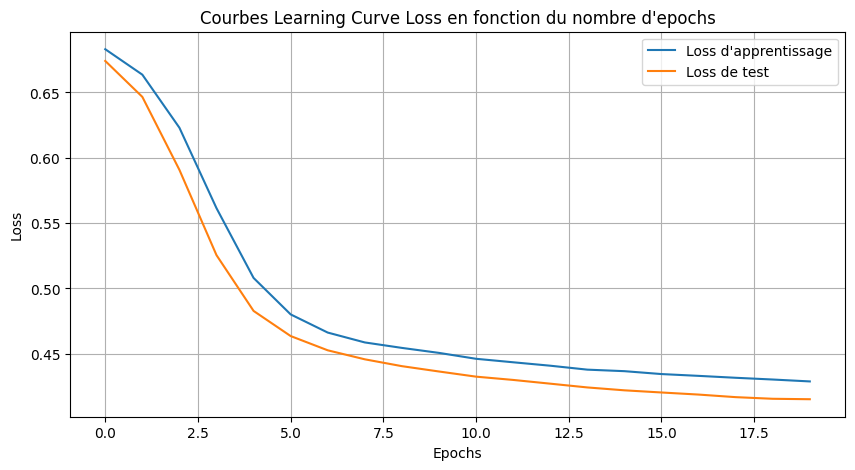

In [ ]:
plot_learning_curve(history_custom, 'loss')

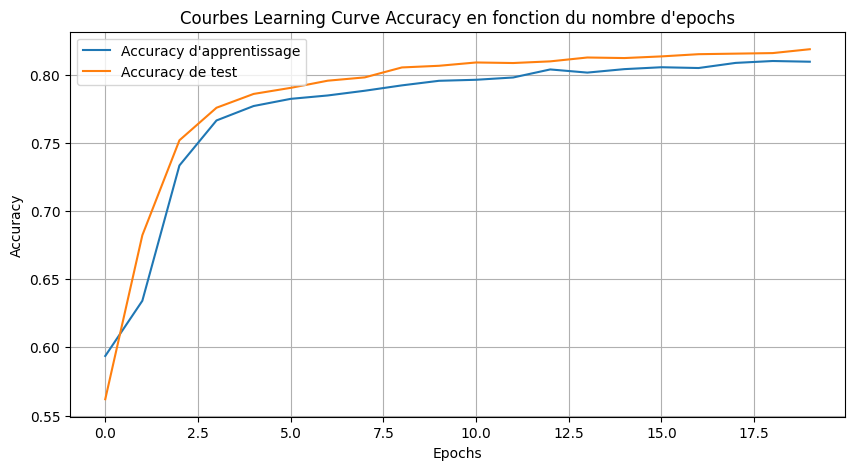

In [ ]:
plot_learning_curve(history_custom, 'accuracy')

# Save model

In [ ]:
model_custom.save(os.path.join(PATH_MODELS, "modele_20_epoch.h5"))

In [ ]:
# Chargement du model
load_name = 'modele_20_epoch.h5'
loaded_model = load(load_name)
loss, accuracy, f1, recall, precission = model_evaluate(loaded_model, test_dataset)

155/155 [==============================] - 5s 33ms/step
Précision (Accuracy) : 56.17 %
Perte (Loss): 0.69 => 69.03 %
F1-score : 49.84 %
Rappel (Recall) : 49.8 %
Précision : 49.8 %


# Train sur 50 epochs

In [ ]:
name_best_model_kevin = os.path.join(PATH_MODELS, 'best_model_50_.h5')
name_model_k = os.path.join(PATH_MODELS, 'model_50.h5')
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath=name_best_model_kevin,
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)

callbacks = [model_ckp]

In [ ]:

# ***********************************************************************
# **************        MODEL       *************************************
# ***********************************************************************
# Créez un modèle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout

# 4. Création du modèle CNN
model = Sequential([
    # Couche de convolution 1
    Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de convolution 2
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de convolution 3
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    #Couche de convolution 4
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de convolution 5
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    # Couche de flatten
    Flatten(),

    # Couche complètement connectée
    Dense(128),
    Activation('relu'),

    # Couche Dopout
    Dropout(0.2),

    # Couche de sortie
    Dense(n_class, activation='softmax')  # La sortie a 2 classes, donc 'softmax' est utilisé
])

# Afficher le résumé du modèle
model.summary()

model.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adadelta(1e-4, name='Adadelta'),
                    metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 activation_40 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 activation_41 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                               

In [ ]:
epochs = 100
start = time.time()
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_dataset,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=callbacks
    )

elapsed_minutes = display_time_in_minutes(start)
print('Time taken for development model {:.2f} min\n'.format(elapsed_minutes))

Epoch 1/30
541/541 [==============================] - 35s 62ms/step - loss: 0.6850 - accuracy: 0.5724 - val_loss: 0.6739 - val_accuracy: 0.5619
Epoch 2/30
541/541 [==============================] - 33s 61ms/step - loss: 0.6611 - accuracy: 0.6565 - val_loss: 0.6425 - val_accuracy: 0.6972
Epoch 3/30
541/541 [==============================] - 36s 66ms/step - loss: 0.6196 - accuracy: 0.7384 - val_loss: 0.5893 - val_accuracy: 0.7555
Epoch 4/30
541/541 [==============================] - 36s 66ms/step - loss: 0.5656 - accuracy: 0.7600 - val_loss: 0.5354 - val_accuracy: 0.7700
Epoch 5/30
541/541 [==============================] - 34s 63ms/step - loss: 0.5215 - accuracy: 0.7656 - val_loss: 0.5003 - val_accuracy: 0.7749
Epoch 6/30
541/541 [==============================] - 33s 60ms/step - loss: 0.4964 - accuracy: 0.7716 - val_loss: 0.4839 - val_accuracy: 0.7802
Epoch 7/30
541/541 [==============================] - 36s 66ms/step - loss: 0.4859 - accuracy: 0.7729 - val_loss: 0.4740 - val_accuracy:

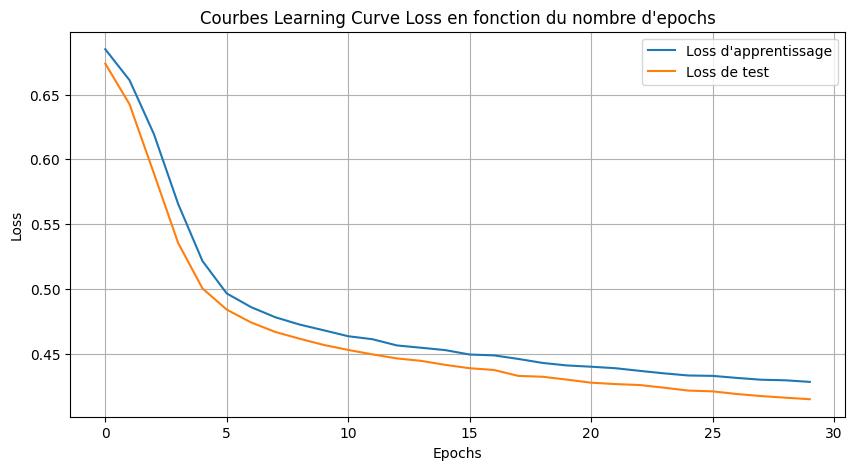

In [ ]:
plot_learning_curve(history, 'loss')

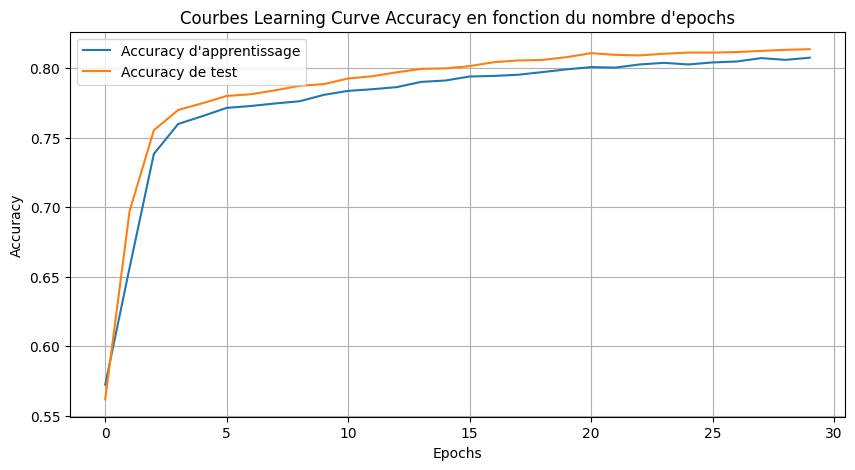

In [ ]:
plot_learning_curve(history, 'accuracy')

In [ ]:
saving_model(model, 'best_model_clasified.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Chargement du model
load_name = 'best_model_clasified.h5'
loaded_model = load(load_name)

In [ ]:
loss, accuracy, f1, recall, precission = model_evaluate(loaded_model, test_dataset)

155/155 [==============================] - 5s 33ms/step
Précision (Accuracy) : 81.04 %
Perte (Loss): 0.43 => 42.56 %
F1-score : 51.37 %
Rappel (Recall) : 51.34 %
Précision : 51.34 %


# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_data_augmented = ImageDataGenerator(rescale=1/255.0,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode="nearest")
test_data_augmented = ImageDataGenerator(rescale=1/255.0)
validation_data_augmented = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_augmented = train_data_augmented.flow_from_directory(
    directory = train_data_dir,
    target_size = (224, 224),
    batch_size=batch_size,
    class_mode="categorical"

)


test_augmented = test_data_augmented.flow_from_directory(
    directory = test_data_dir,
    target_size = (224, 224),
    batch_size=batch_size,
    class_mode="categorical"

)

validation_augmented = validation_data_augmented.flow_from_directory(
    directory = validation_data_dir,
    target_size = (224, 224),
    batch_size=batch_size,
    class_mode="categorical"

)

Found 17293 images belonging to 2 classes.
Found 4942 images belonging to 2 classes.
Found 2470 images belonging to 2 classes.


In [ ]:
name_best_model = os.path.join(PATH_MODELS, 'best_model_augmented_.h5')
name_model = os.path.join(PATH_MODELS, 'model_augmented.h5')
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath=name_best_model,
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)

callbacks = [model_ckp, stop]

In [ ]:

# ***********************************************************************
# **************        MODEL       *************************************
# ***********************************************************************
# Créez un modèle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout

# 4. Création du modèle CNN
model_augmented = Sequential([
    # Couche de convolution 1
    Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de convolution 2
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de convolution 3
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    #Couche de convolution 4
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de convolution 5
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de flatten
    Flatten(),

    # Couche complètement connectée
    Dense(128),
    Activation('relu'),

    # Couche Dopout
    Dropout(0.2),

    # Couche de sortie
    Dense(n_class, activation='softmax')  # La sortie a 2 classes, donc 'softmax' est utilisé
])

# Afficher le résumé du modèle
model_augmented.summary()

model_augmented.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adadelta(1e-3, name='Adadelta'),
                    metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 activation_52 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 activation_53 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                               

In [ ]:
epochs = 50
start = time.time()
with tf.device('/device:GPU:0'):
    history_augmented = model_augmented.fit(
        train_augmented,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_augmented,
        callbacks=callbacks
    )

elapsed_minutes = display_time_in_minutes(start)
print('Time taken for development model {:.2f} min\n'.format(elapsed_minutes))

Epoch 1/50
541/541 [==============================] - 219s 401ms/step - loss: 0.6811 - accuracy: 0.5702 - val_loss: 0.6696 - val_accuracy: 0.5619
Epoch 2/50
541/541 [==============================] - 220s 406ms/step - loss: 0.6580 - accuracy: 0.6309 - val_loss: 0.6367 - val_accuracy: 0.6996
Epoch 3/50
541/541 [==============================] - 220s 407ms/step - loss: 0.6153 - accuracy: 0.7182 - val_loss: 0.5800 - val_accuracy: 0.7603
Epoch 4/50
541/541 [==============================] - 218s 403ms/step - loss: 0.5598 - accuracy: 0.7528 - val_loss: 0.5253 - val_accuracy: 0.7721
Epoch 5/50
541/541 [==============================] - 218s 403ms/step - loss: 0.5196 - accuracy: 0.7648 - val_loss: 0.4911 - val_accuracy: 0.7814
Epoch 6/50
541/541 [==============================] - 220s 407ms/step - loss: 0.4946 - accuracy: 0.7712 - val_loss: 0.4710 - val_accuracy: 0.7891
Epoch 7/50
541/541 [==============================] - 220s 406ms/step - loss: 0.4825 - accuracy: 0.7740 - val_loss: 0.4612 -

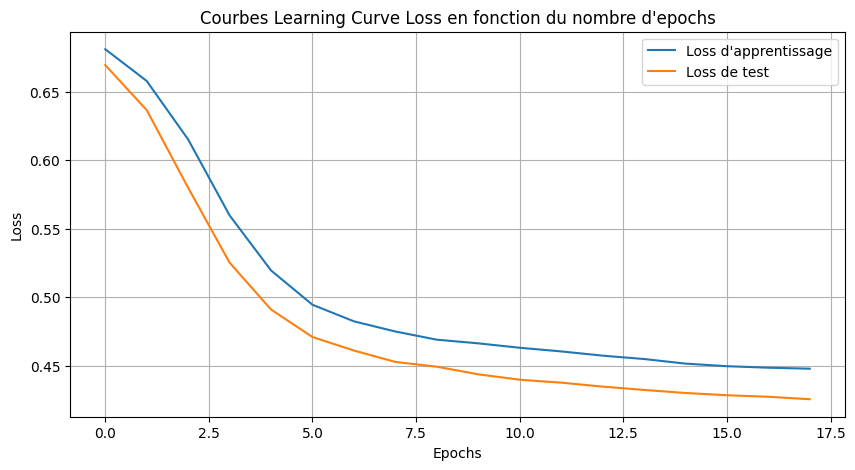

In [ ]:
plot_learning_curve(history_augmented, 'loss')

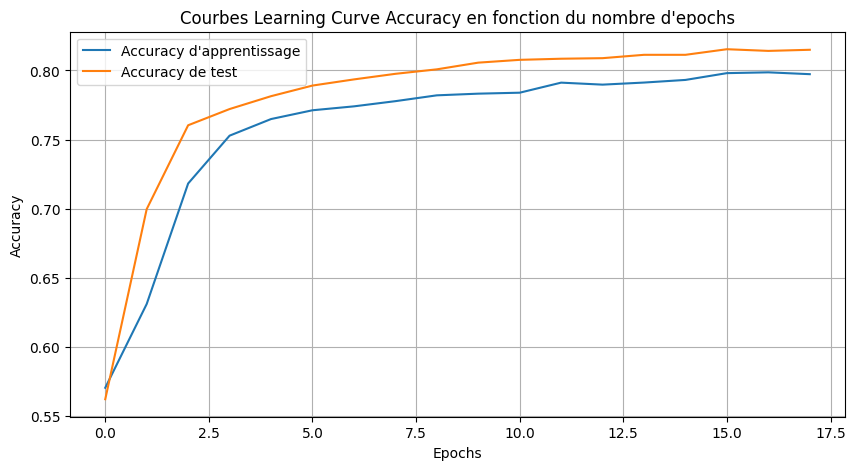

In [ ]:
plot_learning_curve(history_augmented, 'accuracy')

In [ ]:
# Chargement du model
load_name = 'best_model_augmented_.h5'
loaded_model = load(load_name)
loss, accuracy, f1, recall, precission = model_evaluate(loaded_model, test_dataset)

In [ ]:
loss, accuracy, f1, recall, precission = model_evaluate(loaded_model, test_dataset)

155/155 [==============================] - 7s 40ms/step
Précision (Accuracy) : 80.17 %
Perte (Loss): 0.44 => 44.07 %
F1-score : 49.51 %
Rappel (Recall) : 49.47 %
Précision : 49.47 %


# Transfert Learning

In [ ]:
from tensorflow.keras.applications import vgg16

In [ ]:
pretrained_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Utilisation des filtres de VGG 16

In [ ]:
pretrained_model.trainable = False

In [ ]:
flatten_layer = tf.keras.layers.Flatten()

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)
x = flatten_layer(x) # 7*7*512
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(n_class, activation='softmax')(x)

model_pred = tf.keras.Model(inputs, outputs)

In [ ]:
model_pred.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_17 (Flatten)        (None, 25088)             0         
                                                                 
 dropout_17 (Dropout)        (None, 25088)             0         
                                                                 
 dense_50 (Dense)            (None, 128)               3211392   
                                                                 
 dense_51 (Dense)            (None, 2)                 258       
                                                                 
Total params: 17926338 (68.38 MB)
Trainable params: 3211650

In [ ]:
model_pred.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adadelta(1e-3, name='Adadelta'),
                    metrics=['accuracy'])

In [ ]:
name_best_model = os.path.join(PATH_MODELS, 'best_model_pred_.h5')
name_model = os.path.join(PATH_MODELS, 'model_pred.h5')
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath=name_best_model,
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)

callbacks = [model_ckp, stop]

In [ ]:
epochs = 30
start = time.time()
with tf.device('/device:GPU:0'):
    history_pred = model_pred.fit(
        train_dataset,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=callbacks
    )

elapsed_minutes = display_time_in_minutes(start)
print('Time taken for development model {:.2f} min\n'.format(elapsed_minutes))

Epoch 1/30
541/541 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.8924

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


541/541 [==============================] - 95s 176ms/step - loss: 0.2654 - accuracy: 0.8924 - val_loss: 0.3281 - val_accuracy: 0.8543
Epoch 2/30
541/541 [==============================] - 96s 177ms/step - loss: 0.2114 - accuracy: 0.9158 - val_loss: 0.2513 - val_accuracy: 0.9016
Epoch 3/30
541/541 [==============================] - 96s 177ms/step - loss: 0.1760 - accuracy: 0.9309 - val_loss: 0.2357 - val_accuracy: 0.9093
Epoch 4/30
541/541 [==============================] - 96s 177ms/step - loss: 0.1460 - accuracy: 0.9441 - val_loss: 0.2563 - val_accuracy: 0.9134
Epoch 5/30
541/541 [==============================] - 96s 178ms/step - loss: 0.1204 - accuracy: 0.9542 - val_loss: 0.2608 - val_accuracy: 0.9202
Epoch 6/30
541/541 [==============================] - 95s 175ms/step - loss: 0.0998 - accuracy: 0.9628 - val_loss: 0.3044 - val_accuracy: 0.8964
Epoch 7/30
541/541 [==============================] - 95s 175ms/step - loss: 0.0822 - accuracy: 0.9696 - val_loss: 0.2926 - val_accuracy: 0.9

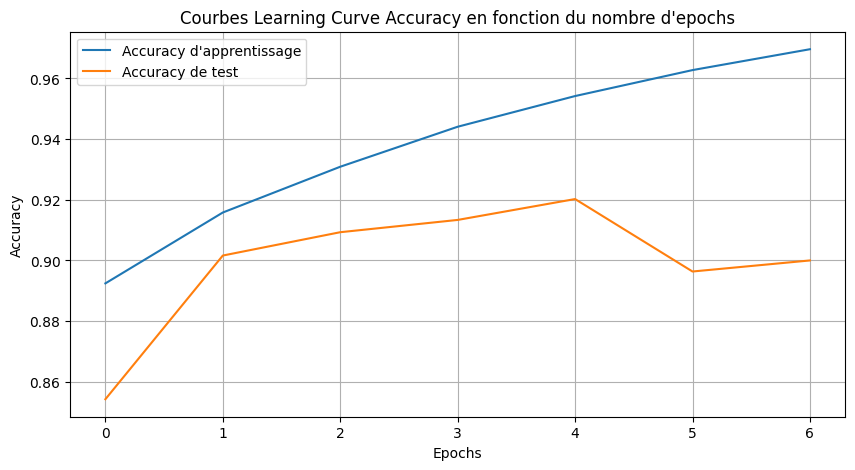

In [ ]:
plot_learning_curve(history_pred, 'accuracy')

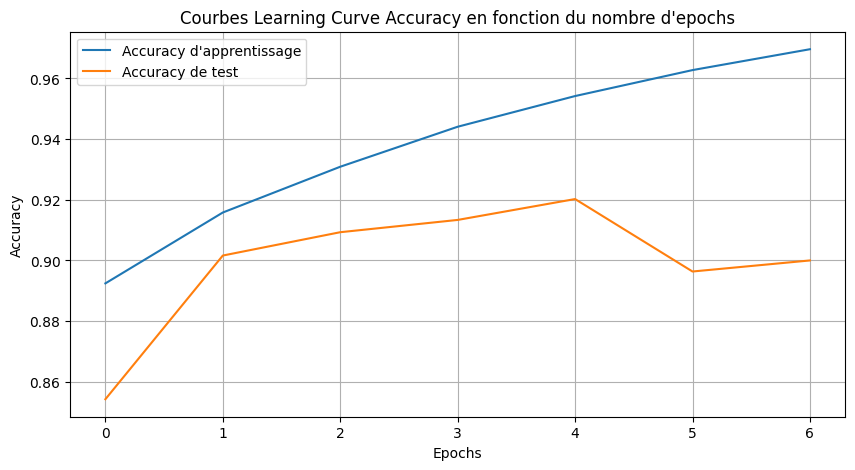

In [ ]:
plot_learning_curve(history_pred, 'accuracy')

In [ ]:
saving_model(model_pred, 'best_model_vgg16.h5')

In [ ]:
# Chargement du model
load_name = 'best_model_pred_.h5'
loaded_model = load(load_name)
loss, accuracy, f1, recall, precission = model_evaluate(loaded_model, test_dataset)

In [ ]:
loss, accuracy, f1, recall, precission = model_evaluate(loaded_model, test_dataset)

155/155 [==============================] - 21s 133ms/step
Précision (Accuracy) : 94.82 %
Perte (Loss): 0.15 => 14.53 %
F1-score : 50.36 %
Rappel (Recall) : 50.32 %
Précision : 50.32 %


# model DenseNet169

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Créez un modèle DenseNet169 pré-entraîné sans les couches supérieures
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)

# Ajoutez des couches personnalisées au-dessus du modèle de base
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(n_class, activation='softmax')(x)

# Créez le modèle final en reliant les couches
model_dense_net = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compilez le modèle
model_dense_net.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adadelta(1e-3, name='Adadelta'),
                    metrics=['accuracy'])

# Affichez un résumé de l'architecture du modèle
model_dense_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, 230, 230, 3)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_6[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
name_best_model = os.path.join(MODEL_DIR, 'best_model_dense_net_.h5')
name_model = os.path.join(MODEL_DIR, 'model_dense_net.h5')
model_ckp = tf.keras.callbacks.ModelCheckpoint(filepath=name_best_model,
                            monitor="val_accuracy",
                            mode="max",
                            save_best_only=True)
stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)

callbacks = [model_ckp, stop]

In [ ]:
epochs = 10
start = time.time()
with tf.device('/device:GPU:0'):
    history_dense_net = model_dense_net.fit(
        train_dataset,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=callbacks
    )

elapsed_minutes = display_time_in_minutes(start)
print('Time taken for development model {:.2f} min\n'.format(elapsed_minutes))

Epoch 1/10
541/541 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.6622

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


541/541 [==============================] - 281s 472ms/step - loss: 0.6679 - accuracy: 0.6622 - val_loss: 0.3612 - val_accuracy: 0.8575
Epoch 2/10
541/541 [==============================] - 249s 460ms/step - loss: 0.4115 - accuracy: 0.8173 - val_loss: 0.2563 - val_accuracy: 0.9101
Epoch 3/10
541/541 [==============================] - 247s 455ms/step - loss: 0.3236 - accuracy: 0.8664 - val_loss: 0.2103 - val_accuracy: 0.9275
Epoch 4/10
541/541 [==============================] - 252s 465ms/step - loss: 0.2742 - accuracy: 0.8917 - val_loss: 0.1846 - val_accuracy: 0.9356
Epoch 5/10
541/541 [==============================] - 252s 465ms/step - loss: 0.2387 - accuracy: 0.9075 - val_loss: 0.1695 - val_accuracy: 0.9425
Epoch 6/10
541/541 [==============================] - 249s 460ms/step - loss: 0.2196 - accuracy: 0.9152 - val_loss: 0.1587 - val_accuracy: 0.9445
Epoch 7/10
541/541 [==============================] - 252s 465ms/step - loss: 0.2018 - accuracy: 0.9225 - val_loss: 0.1510 - val_accura

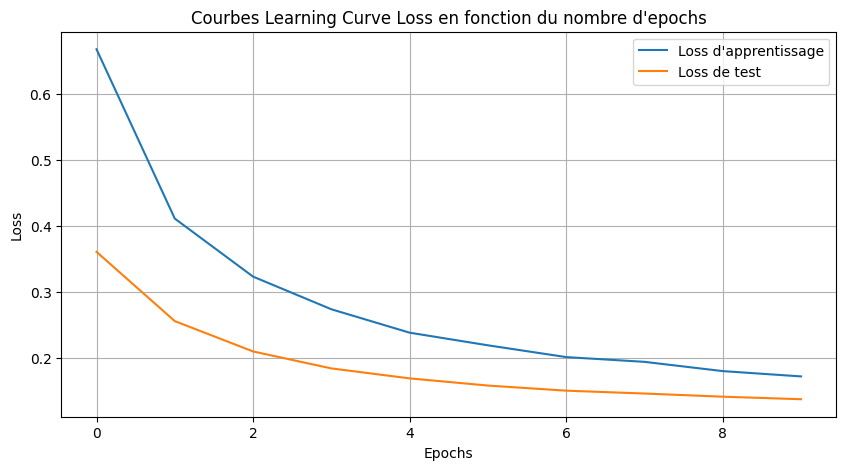

In [ ]:
plot_learning_curve(history_dense_net, 'loss')

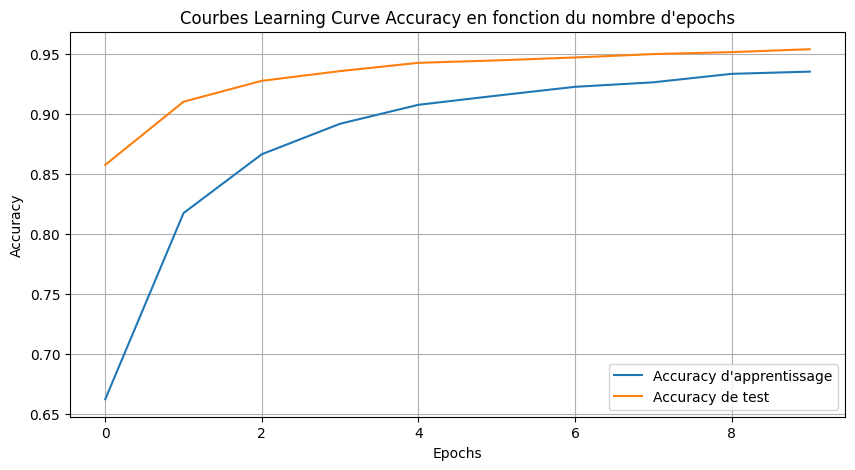

In [ ]:
plot_learning_curve(history_dense_net, 'accuracy')

In [ ]:
saving_model(model_dense_net, 'model_dense_net.h5')

In [ ]:
# Chargement du model
load_name = 'best_model_pred_.h5'
# loaded_model = load(load_name)
loss, accuracy, f1, recall, precission = model_evaluate(model_dense_net, test_dataset)

155/155 [==============================] - 18s 117ms/step
Précision (Accuracy) : 95.43 %
Perte (Loss): 0.13 => 12.77 %
F1-score : 50.42 %
Rappel (Recall) : 50.38 %
Précision : 50.38 %


## SAVE MODEL

In [ ]:
# ***********************************************************************
# *****************        SAVE MODEL        ****************************
# ***********************************************************************
model_kevin.save(name_model)

In [ ]:
# Chargement du model
load_name = 'best_model_dense_net_.h5'
loaded_model = load(load_name)
loss, accuracy, f1, recall, precission = model_evaluate(loaded_model, test_dataset)

155/155 [==============================] - 21s 118ms/step
Précision (Accuracy) : 96.54 %
Perte (Loss): 0.1 => 10.14 %
F1-score : 49.59 %
Rappel (Recall) : 49.55 %
Précision : 49.55 %


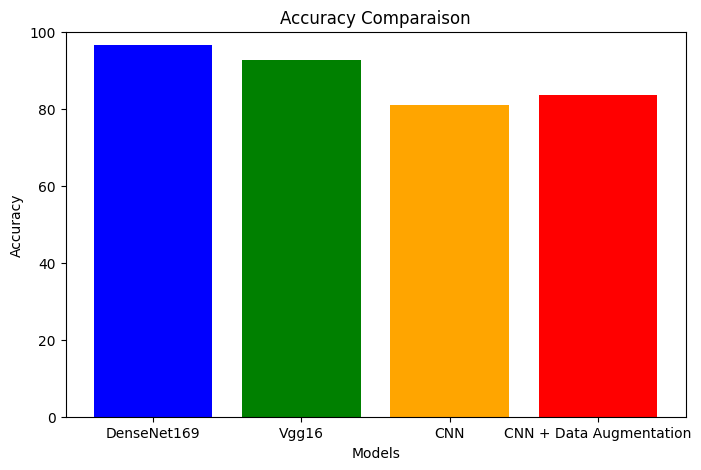

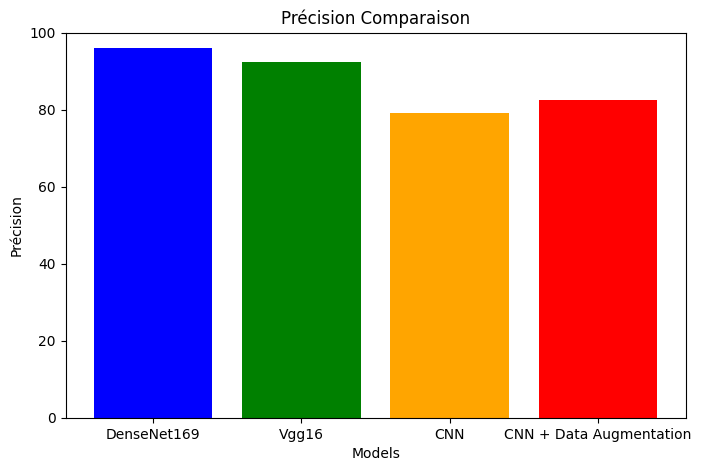

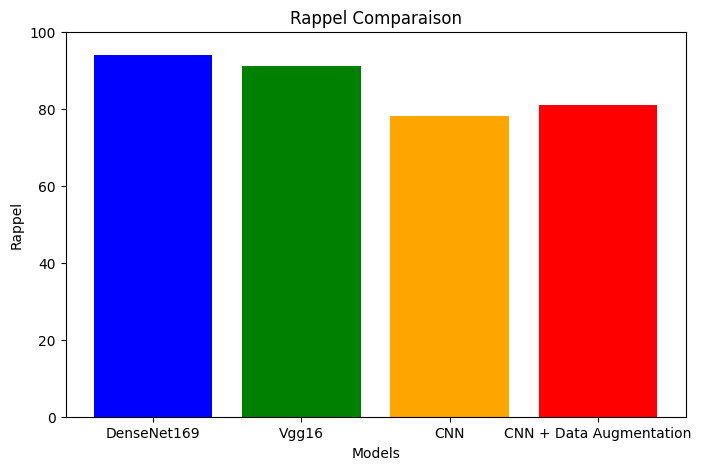

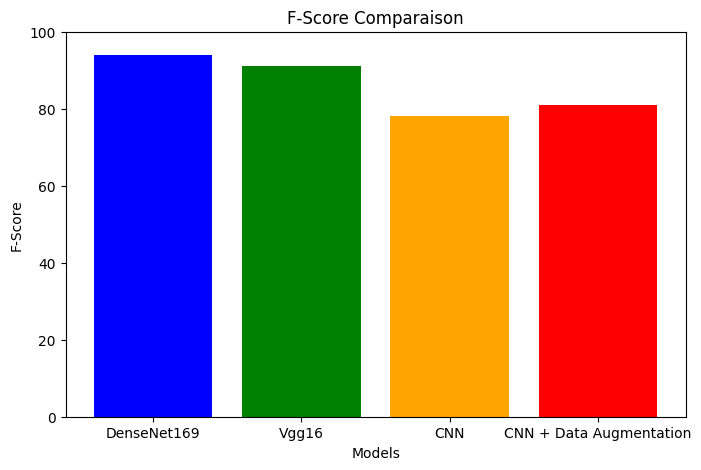

In [ ]:
import matplotlib.pyplot as plt

# Métriques et valeurs
metrics = ['Accuracy', 'Précision', 'Rappel', 'F-Score']
densenet169_values = [96.53, 96.10, 94, 94]
vgg16_values = [92.62, 92.44, 91, 91]
cnn_values = [81.04, 79.07, 78, 78]
cnn_data_augmentation_values = [83.50, 82.4, 81.03, 81.03]

# Créer un histogramme pour chaque métrique
for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    plt.bar(['DenseNet169', 'Vgg16', 'CNN', 'CNN + Data Augmentation'],
            [densenet169_values[i], vgg16_values[i], cnn_values[i], cnn_data_augmentation_values[i]],
            color=['blue', 'green', 'orange', 'red'])
    plt.title(metric + ' Comparaison')
    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.ylim(0, 100)  # Ajustez la plage y en fonction de vos données
    plt.grid(False)
    plt.show()